In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler

# Regression problem

## Loading dataset
Load the Boston Housing dataset from the Keras library.

Due to the ethical issues surrounding the Boston housing dataset, primarily the inclusion of a racist feature engineered by the dataset's authors, the Boston housing dataset will not be used. Alternatively, the California housing dataset, available in SKlearn, will be used instead.

In [2]:
ca_housing = fetch_california_housing(as_frame=True)

In [3]:
feature_df = ca_housing.data
target_df = ca_housing.target

## Explore and preprocess
Explore and preprocess the data (e.g., normalization, one-hot encoding, etc.).

In [4]:
(num_samples, num_features) = feature_df.shape

print(f'Sample size: {num_samples}')
print(f'Number of features: {num_features}')

Sample size: 20640
Number of features: 8


In [5]:
# concatenate all train and test data and targets together
full_df = pd.concat([feature_df, target_df], axis=1)

In [6]:
full_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### Correlation Matrix

In [7]:
correlation_matrix = full_df.corr()

corr_w_target = correlation_matrix['MedHouseVal']

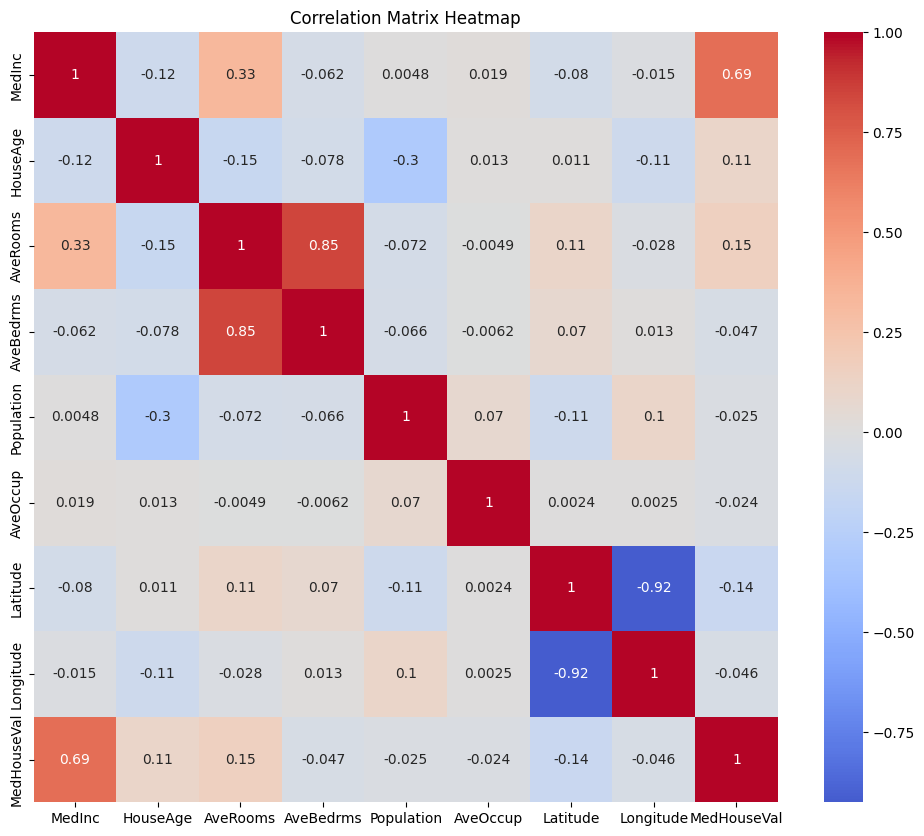

In [8]:
plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
print(f'Correlations with the target variable:\n{corr_w_target}')

Correlations with the target variable:
MedInc         0.688075
HouseAge       0.105623
AveRooms       0.151948
AveBedrms     -0.046701
Population    -0.024650
AveOccup      -0.023737
Latitude      -0.144160
Longitude     -0.045967
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


### Feature histplots

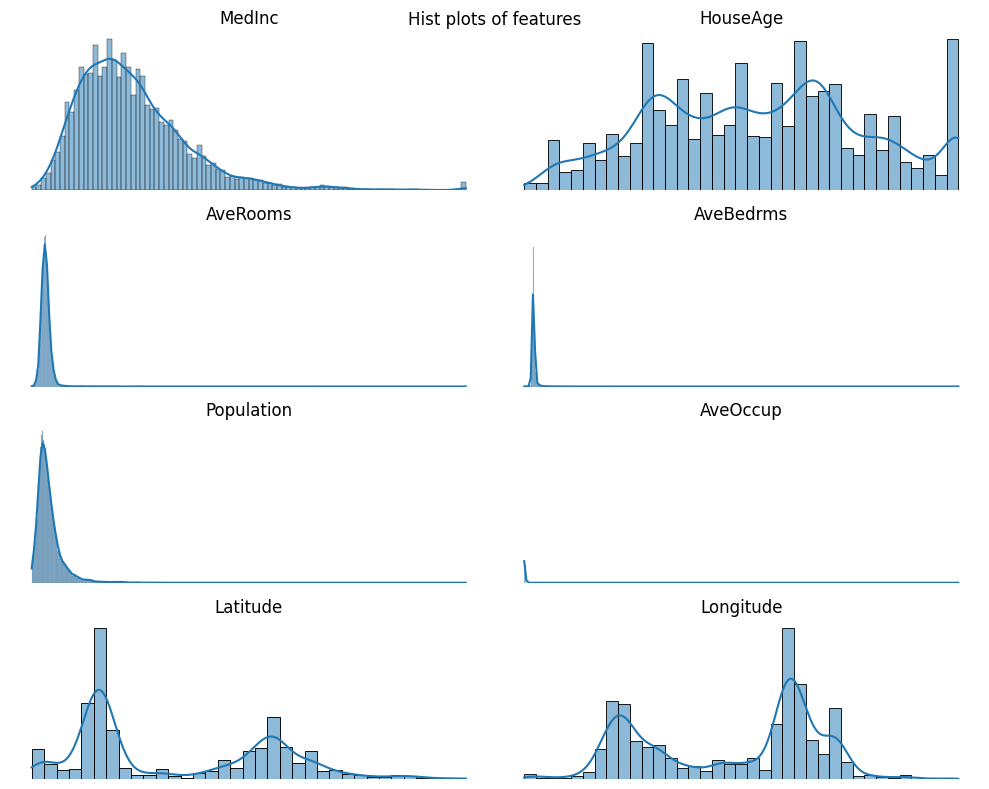

In [10]:
num_rows = 4
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.histplot(feature_df.iloc[:,i], ax=axes[row_idx, col_idx], kde=True)
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Hist plots of features')
plt.show()

### Feature boxplots

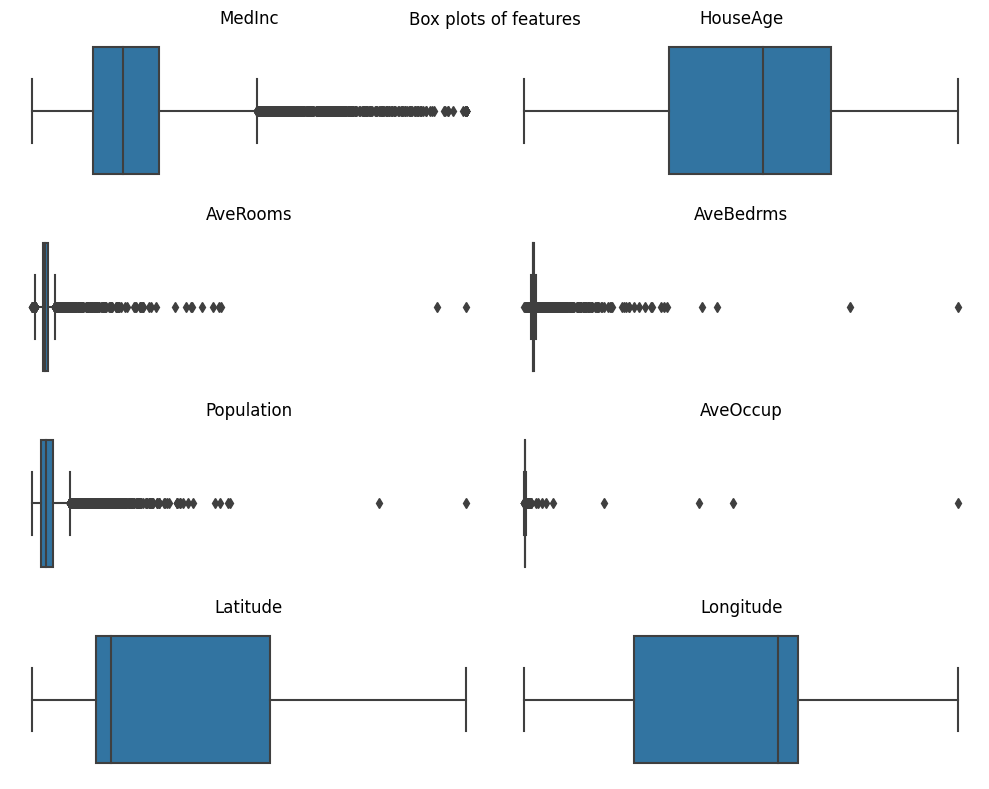

In [11]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.boxplot(x=feature_df.iloc[:,i], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Box plots of features')
plt.show()

### Address significant outliers

In [12]:
full_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [13]:
full_df[full_df['AveRooms'] > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,2.06300
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,4.37500
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,5.00001
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500
2395,3.8750,23.0,50.837838,10.270270,64.0,1.729730,37.12,-119.34,1.25000
9676,3.2431,14.0,52.848214,11.410714,265.0,2.366071,37.64,-119.02,2.21400
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06,1.70000
11862,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25,0.67500
12447,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49,0.87500


In [14]:
# drop outliers, averooms 132 and 141 and AveBedrms 34 and 25
full_df = full_df.loc[full_df['AveRooms'] < 65]

In [15]:
full_df[full_df['AveOccup'] > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.675
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.546
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.625
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.250
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29,1.625
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.500
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.375


In [16]:
# drop outliers, aveoccup 100+
full_df = full_df.loc[full_df['AveOccup'] < 100]

In [17]:
full_df[full_df['Population'] > 20000]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
9880,2.3087,11.0,5.364518,1.059684,28566.0,4.696810,36.64,-121.79,1.188
15360,2.5729,14.0,5.270497,1.010484,35682.0,7.482072,33.35,-117.42,1.344


In [18]:
# drop outliers, population 20k+
full_df = full_df.loc[full_df['Population'] < 20000]

### New boxplots with significant outliers removed

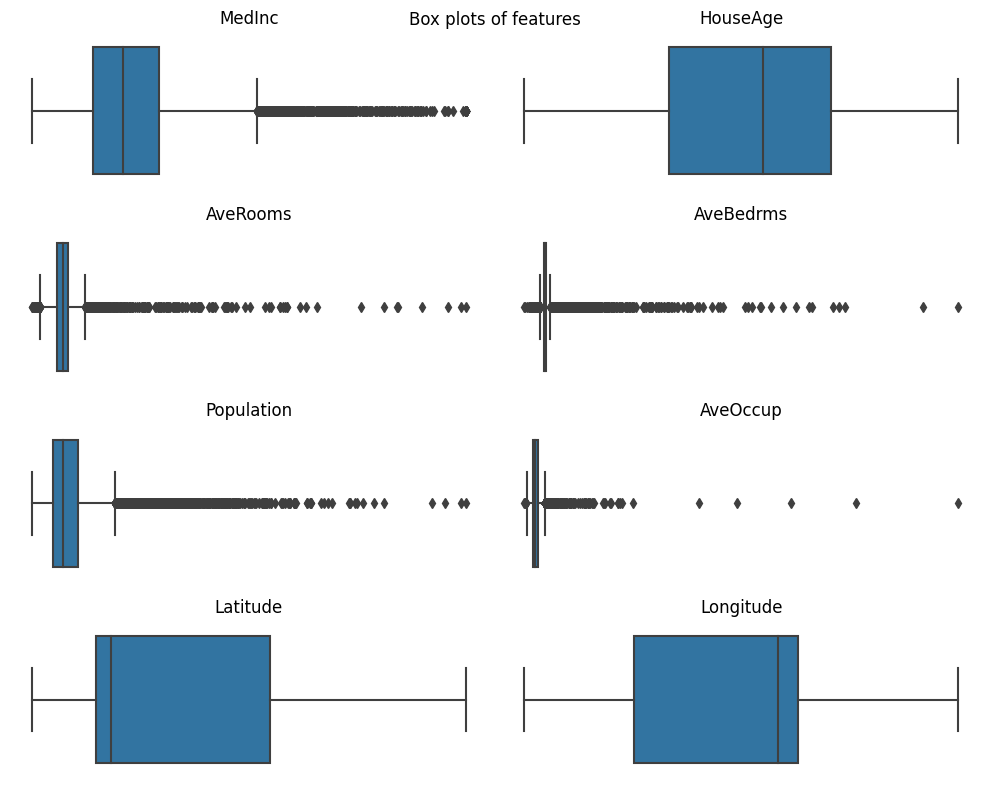

In [19]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.boxplot(x=full_df.iloc[:,i], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Box plots of features')
plt.show()

## TTS
Split the data into training and testing sets.

In [20]:
X = full_df.drop(['MedHouseVal'], axis=1)
y = full_df['MedHouseVal']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Feature and target scaling

In [22]:
scaler_x = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [23]:
scaler_y = MinMaxScaler()

y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
y_train_arr = y_train_arr.reshape(-1, 1)
y_test_arr = y_test_arr.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_arr)
y_test_scaled = scaler_y.transform(y_test_arr)

## Model definition
Define a deep neural network architecture for regression using Keras.

In [24]:
def create_regression_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [25]:
baseline_regression_model = create_regression_model()

## Model training and testing
Train the model on the training set and evaluate its performance on the testing set.

### Model training

In [26]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('baseline_regression.h5', save_best_only=True)

history = baseline_regression_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


413/413 [==============================] - 1s 2ms/step - loss: 0.0336 - mae: 0.1341 - val_loss: 0.0216 - val_mae: 0.1079
Epoch 2/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0221 - mae: 0.1076 - val_loss: 0.0190 - val_mae: 0.0959
Epoch 3/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0197 - mae: 0.1011 - val_loss: 0.0170 - val_mae: 0.0945
Epoch 4/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0180 - mae: 0.0961 - val_loss: 0.0163 - val_mae: 0.0928
Epoch 5/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0175 - mae: 0.0940 - val_loss: 0.0159 - val_mae: 0.0861
Epoch 6/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0164 - mae: 0.0908 - val_loss: 0.0154 - val_mae: 0.0914
Epoch 7/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0160 - mae: 0.0898 - val_loss: 0.0148 - val_mae: 0.0858
Epoch 8/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0156 - mae:

### Basemodel training perf

In [34]:
def training_plots(history, metric):
    epochs = len(history.history[f'{metric}'])
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=range(1, epochs + 1), y=history.history[f'{metric}'], label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs + 1), y=history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.title(f'Training and Validation {metric}')
    plt.legend()
    plt.show()

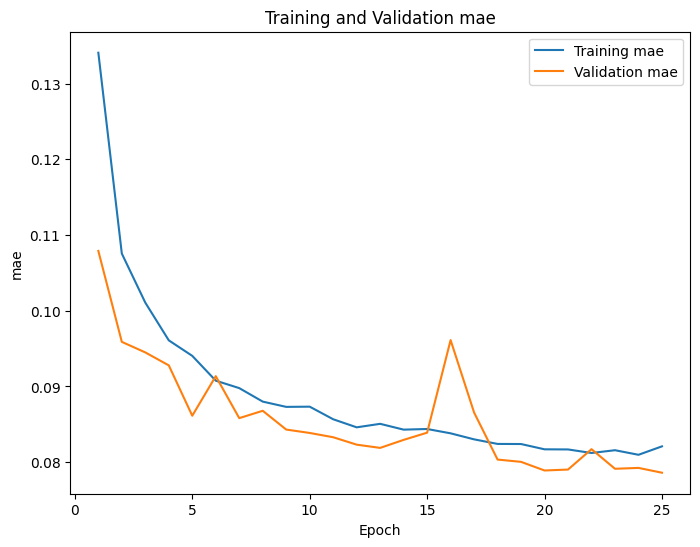

In [35]:
training_plots(history, 'mae')

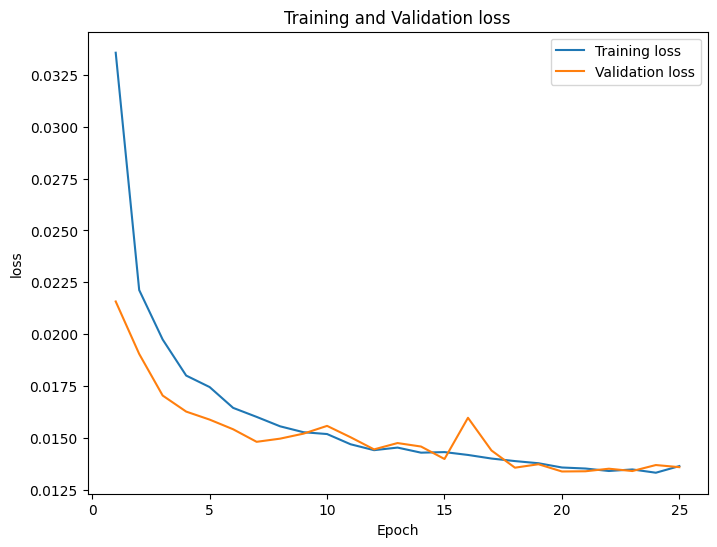

In [36]:
training_plots(history, 'loss')

### Basemodel performance in testing

In [38]:
loss, mae = baseline_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test Loss: 0.0132
Test MAE: 0.0777


In [39]:
y_pred = baseline_regression_model.predict(X_test_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)

129/129 [==============================] - 0s 631us/step


In [71]:
def testing_plot(y_true, y_pred, tuned=0):
    if tuned:
        plt.scatter(y_true, y_pred, color='green', label='Tuned model')
    else:
        plt.scatter(y_true, y_pred, color='blue', label='Baseline model')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('True vs Pred')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')

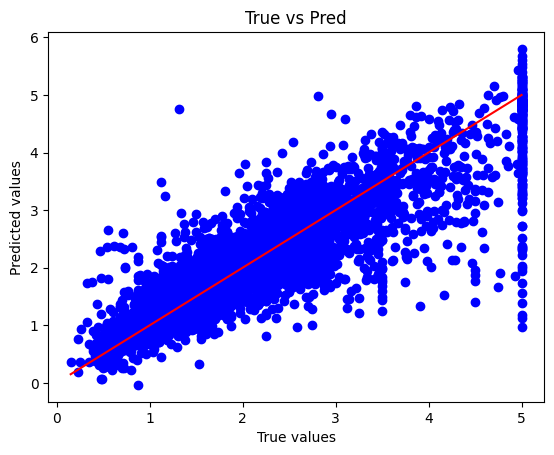

In [72]:
testing_plot(y_test, y_pred_inv)
plt.show()

## Parameter tuning
Tune the hyperparameters of the model to achieve better performance (e.g., number of hidden layers, activation functions, learning rate, number of epochs, etc.).

In [44]:
tuning_regression_model = KerasRegressor(build_fn=create_regression_model, verbose=0)

param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50],
    'dropout_rate': [0.2, 0.3]
}

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_13288\335603139.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tuning_regression_model = KerasRegressor(build_fn=create_model, verbose=0)


In [45]:
regressor_grid = GridSearchCV(estimator=tuning_regression_model, param_grid=param_grid, cv=3, n_jobs=-1)

model_checkpoint = ModelCheckpoint('tuning_regression.h5', save_best_only=True)

In [46]:
grid_result = regressor_grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping, model_checkpoint], validation_split=0.2)

In [54]:
gs_regression_df = pd.DataFrame(grid_result.cv_results_)
gs_regression_df = gs_regression_df.drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score'])

gs_regression_df = gs_regression_df.sort_values(by='rank_test_score', ascending=True)
gs_regression_df.head(20).round(4)

,param_activation,param_batch_size,param_dropout_rate,param_epochs,param_optimizer,mean_test_score,std_test_score,rank_test_score
2,relu,16,0.2,50,adam,-0.0121,0.0002,1
10,relu,32,0.2,50,adam,-0.0122,0.0004,2
6,relu,16,0.3,50,adam,-0.0123,0.0002,3
14,relu,32,0.3,50,adam,-0.0123,0.0004,4
18,relu,64,0.2,50,adam,-0.0128,0.0005,5
22,relu,64,0.3,50,adam,-0.0128,0.0002,6
8,relu,32,0.2,20,adam,-0.0130,0.0004,7
0,relu,16,0.2,20,adam,-0.0131,0.0003,8
20,relu,64,0.3,20,adam,-0.0135,0.0004,9
4,relu,16,0.3,20,adam,-0.0135,0.0009,10


## Model evaluation
Compare the performance of the tuned model with the baseline model (i.e., the initial model without any hyperparameter tuning).

In [56]:
activation = 'relu'
batch_size = 16
dropout_rate = 0.2
epochs = 50
optimizer = 'adam'

In [57]:
tuned_regression_model = create_regression_model(activation=activation, optimizer=optimizer, dropout_rate=dropout_rate)

In [58]:
model_checkpoint = ModelCheckpoint('tuned_regression.h5', save_best_only=True)

history = tuned_regression_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
826/826 [==============================] - 2s 1ms/step - loss: 0.0272 - mae: 0.1210 - val_loss: 0.0198 - val_mae: 0.1016
Epoch 2/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0202 - mae: 0.1021 - val_loss: 0.0179 - val_mae: 0.1011
Epoch 3/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0184 - mae: 0.0973 - val_loss: 0.0162 - val_mae: 0.0912
Epoch 4/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0169 - mae: 0.0924 - val_loss: 0.0154 - val_mae: 0.0863
Epoch 5/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0163 - mae: 0.0913 - val_loss: 0.0152 - val_mae: 0.0882
Epoch 6/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0158 - mae: 0.0890 - val_loss: 0.0155 - val_mae: 0.0859
Epoch 7/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0153 - mae: 0.0878 - val_loss: 0.0149 - val_mae: 0.0891
Epoch 8/50
826/826 [==============================] - 1s 1ms/step - loss: 0.

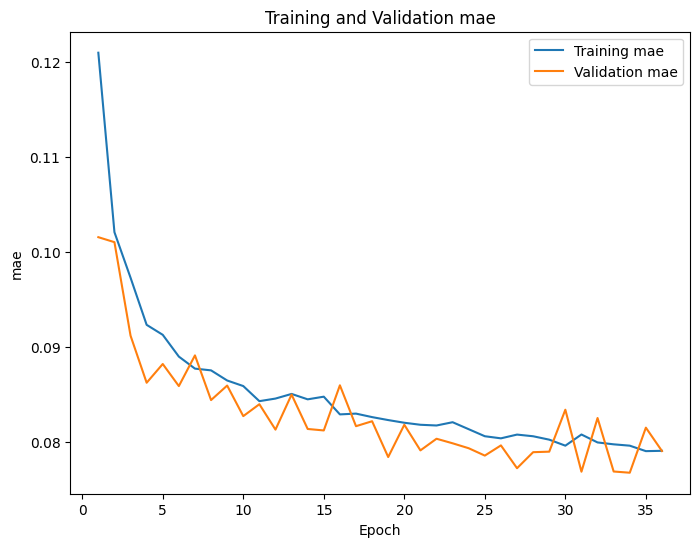

In [59]:
training_plots(history, 'mae')

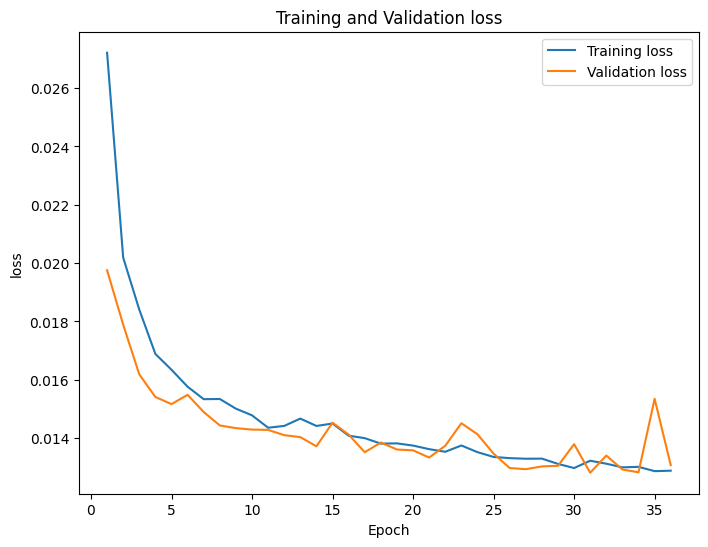

In [60]:
training_plots(history, 'loss')

In [63]:
baseline_loss, baseline_mae = baseline_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
tuned_loss, tuned_mae = tuned_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'Baseline model test loss: {baseline_loss:.4f}')
print(f'Baseline model test MAE: {baseline_mae:.4f}')
print(f'Tuned model test loss: {tuned_loss:.4f}')
print(f'Tuned model test MAE: {tuned_mae:.4f}')

Baseline model test loss: 0.0132
Baseline model test MAE: 0.0777
Tuned model test loss: 0.0128
Tuned model test MAE: 0.0759


In [68]:
y_pred_baseline = baseline_regression_model.predict(X_test_scaled)
y_pred_tuned = tuned_regression_model.predict(X_test_scaled)

y_pred_baseline_inv = scaler_y.inverse_transform(y_pred_baseline)
y_pred_tuned_inv = scaler_y.inverse_transform(y_pred_tuned)

129/129 [==============================] - 0s 600us/step


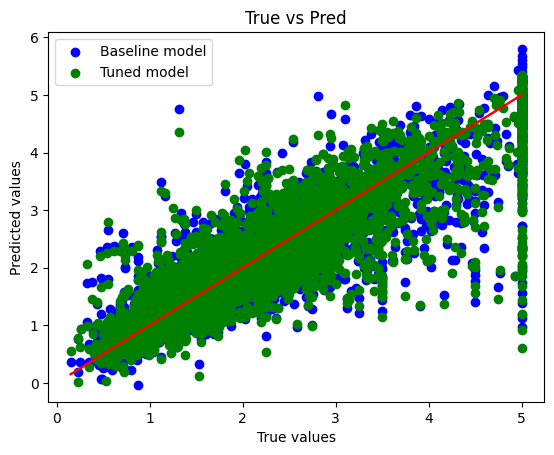

In [73]:
testing_plot(y_test, y_pred_baseline_inv)
testing_plot(y_test, y_pred_tuned_inv, tuned=1)
plt.legend()
plt.show()

# Classification problem

## Load data
Load the Boston Housing dataset from the Keras library.

## EDA
Explore and preprocess the data (e.g., normalization, one-hot encoding, etc.).

## Binary target
Convert the target variable into a binary variable (i.e., expensive or not expensive).

## TTS
Split the data into training and testing sets.

## Define model
Define a deep neural network architecture for classification using Keras.

In [ ]:
def create_classification_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Train and test model
Train the model on the training set and evaluate its performance on the testing set.

## Parameter tuning
Tune the hyperparameters of the model to achieve better performance (e.g., number of hidden layers, activation functions, learning rate, number of epochs, etc.).

In [ ]:
tuning_classification_model = KerasClassifier(build_fn=create_classification_model, verbose=0)

In [ ]:
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50],
    'dropout_rate': [0.2, 0.3]
}

## Model evaluation
Compare the performance of the tuned model with the baseline model (i.e., the initial model without any hyperparameter tuning).